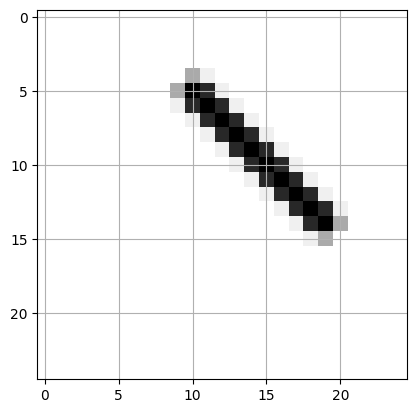

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def rasterize(lines, shape, **kwargs):
    #Kudos to Andy Jones (https://stackoverflow.com/questions/31638651/how-can-i-draw-lines-into-numpy-arrays)
    """Rasterizes an array of lines onto an array of a specific shape using
    Matplotlib. The output lines are antialiased.

    Be wary that the line coordinates are in terms of (i, j), _not_ (x, y).

    Args: 
        lines: (line x end x coords)-shaped array of floats
        shape: (rows, columns) tuple-like

    Returns:
        arr: (rows x columns)-shaped array of floats, with line centres being
        1. and empty space being 0.
    """
    lines, shape = np.array(lines), np.array(shape)

    # Flip from (i, j) to (x, y), as Matplotlib expects
    lines = lines[:, :, ::-1]

    # Create our canvas
    fig = plt.figure()
    fig.set_size_inches(shape[::-1]/fig.get_dpi())

    # Here we're creating axes that cover the entire figure
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')

    # And now we're setting the boundaries of the axes to match the shape
    ax.set_xlim(0, shape[1])
    ax.set_ylim(0, shape[0])
    ax.invert_yaxis()

    # Add the lines
    lines = mpl.collections.LineCollection(lines, color='k', **kwargs)
    ax.add_collection(lines)

    # Then draw and grab the buffer
    fig.canvas.draw_idle()
    arr = (np.frombuffer(fig.canvas.get_renderer().buffer_rgba(), np.uint8)
                        .reshape((*shape, 4))
                        [:, :, :3]
                        .mean(-1))

    # And close the figure for all the IPython folk out there
    plt.close()

    # Finally, flip and reverse the array so empty space is 0.
    return 1 - arr/255.

d = rasterize([[[5, 10], [15, 20]]], [25, 25])
plt.imshow(d, cmap='Greys')
plt.grid()

#d = np.zeros((101,101))
#d = weighted_line(10, 10, 20, 20, 1, rmin=0, rmax=np.inf)
#d = np.array(d)
#d.shape

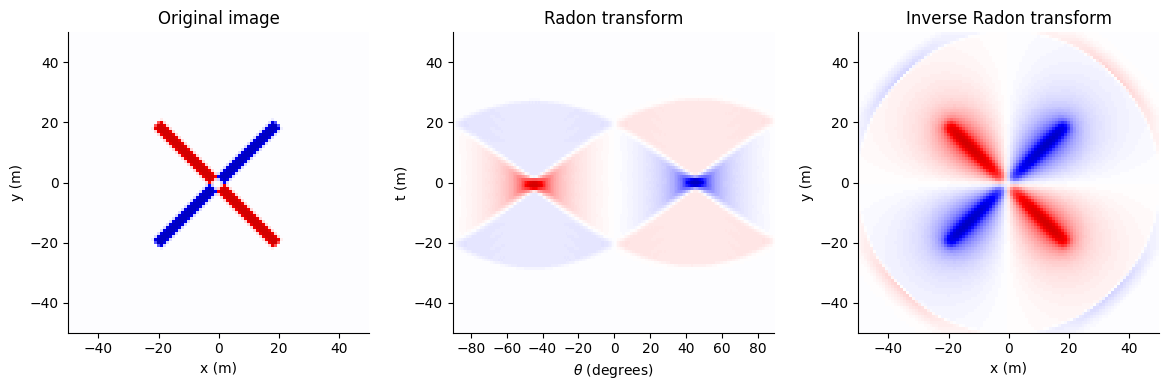

In [5]:
""" Radon Transform as described in Birkfellner, Wolfgang. Applied Medical Image Processing: A Basic Course. [p. 344] """
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import skimage



def create_wave_arc(nx: int = 101, n: int = 3, R: int = 45) -> np.ndarray:
    """Arc of a wave image.
        n: number of wave arc elements
        R: wave arc radius in index units"""
    angle_max = np.deg2rad(55)  # Maximum angle
    x_center = int(0.5 * (nx))  # Center of the arc in index units
    y_center = int(0.85 * (nx))  # Center of the arc in index units
    x_circle, y_circle = [], []
    image = np.zeros((nx, nx))

    # Create wave arc segments
    for angle in np.linspace(-angle_max, angle_max, 2 * n):
        angle = angle + np.pi
        _x = R * np.sin(angle) + x_center
        _y = R * np.cos(angle) + y_center
        x_circle.append(_x)
        y_circle.append(_y)

    # Create image from wave arc segments by rasterizing
    for i in range(len(y_circle) - 1):
        image += rasterize(
            [[[x_circle[i], y_circle[i]], [x_circle[i + 1], y_circle[i + 1]]]],
            image.shape,
            lw=1.5)
        image -= 0.5 * rasterize([[[x_circle[i], y_circle[i] - 2],
                                   [x_circle[i + 1], y_circle[i + 1] - 2]]],
                                 image.shape,
                                 lw=1.5)
        image -= 0.5 * rasterize([[[x_circle[i], y_circle[i] + 2],
                                   [x_circle[i + 1], y_circle[i + 1] + 2]]],
                                 image.shape,
                                 lw=1.5)
    image = np.flipud(np.rot90(image))
    return image


def forward_radon(image, projections_n):
    sinogram = np.zeros((image.shape[0], projections_n), dtype='float64')
    angles = np.linspace(-90, 90, projections_n, endpoint=False)
    for sinogram_col_idx in range(projections_n):
        rot_angle = angles[sinogram_col_idx]
        rot_image = skimage.transform.rotate(image,
                                             rot_angle).astype('float64')
        sinogram[:, sinogram_col_idx] = np.sum(rot_image, axis=1)
        #print(rot_angle)
        #plt.imshow(rot_image, cmap="seismic_r", extent = (x_vec[0], x_vec[-1], x_vec[0], x_vec[-1]), origin='lower')
        #plt.show()
    return sinogram, angles


def inverse_radon(sinogram, projections_n, angles):
    n, m = sinogram.shape
    image = np.zeros((n, n), dtype='float64')
    for sinogram_col_idx in range(projections_n):
        rot_angle = angles[sinogram_col_idx]
        projection = np.tile(sinogram[:, sinogram_col_idx], (n, 1))
        rotated = skimage.transform.rotate(projection, rot_angle)
        image += rotated
    image = np.flipud(np.rot90(image))
    return image

n_projections = 200
nx = 101
x_vec = np.arange(nx) - nx // 2
model = 'cross'

if model == 'wavefront':
    n=50
    image = create_wave_arc(n=n, nx=nx)
elif model == 'cross':
    image = np.zeros((nx, nx))
    image += rasterize([[[30, 30], [70, 70]]], image.shape, lw=2.5)
    image -= rasterize([[[70, 30], [30, 70]]], image.shape, lw=2.5)
radon, angles = forward_radon(image, n_projections)
iradon = inverse_radon(radon, n_projections, angles)

# Plot the original and the radon transformed image
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].matshow(image, cmap="seismic_r", vmin=-1.5*image.max(), vmax=1.5*image.max(), extent = (x_vec[0], x_vec[-1], x_vec[0], x_vec[-1]), origin='lower')
axs[1].matshow(radon, cmap="seismic_r", vmin=-1.5*radon.max(), vmax=1.5*radon.max(), extent = (angles[0], angles[-1], x_vec[0], x_vec[-1]), origin='lower')
axs[2].matshow(iradon, cmap="seismic_r", vmin=-1.5*iradon.max(), vmax=1.5*iradon.max() , extent = (x_vec[0], x_vec[-1], x_vec[0], x_vec[-1]), origin='lower')

axs[0].set_title("Original image")
axs[1].set_title("Radon transform")
axs[2].set_title("Inverse Radon transform")
for ax in [axs[0], axs[2]]:
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')

axs[1].set_xlabel(r'$\theta$ (degrees)')
axs[1].set_ylabel('t (m)')

#Axis labels to bottom
for ax in axs:
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_aspect('equal')

axs[1].set_aspect('auto')
plt.tight_layout()

fig.savefig(f'___figs/forward_inverse_radon_{model}_n{n}_n_projections{n_projections}.png', dpi=300)
plt.show()


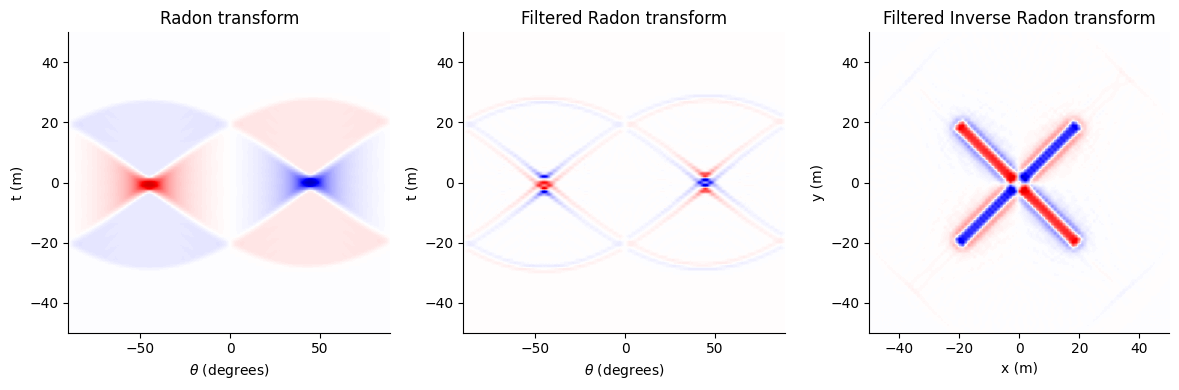

In [20]:
filtered_radon = radon.copy()

filter = np.array([-.5, 1, -.5])

#High-pass filter
for col in range(filtered_radon.shape[1]):
    filtered_radon[:, col] = np.convolve(filtered_radon[:, col], filter, mode='same')

filtered_iradon = inverse_radon(filtered_radon, n_projections, angles)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(radon,
              cmap='seismic_r',
              extent=(angles[0], angles[-1], x_vec[0], x_vec[-1]),
              origin='lower',
              vmin = -1.5*radon.max(), vmax = 1.5*radon.max())
axs[1].imshow(filtered_radon,
              cmap='seismic_r',
              extent=(angles[0], angles[-1], x_vec[0], x_vec[-1]),
              origin='lower',
                vmin = -1.5*filtered_radon.max(), vmax = 1.5*filtered_radon.max())
axs[2].imshow(filtered_iradon,
              cmap='seismic_r',
              extent=(x_vec[0], x_vec[-1], x_vec[0], x_vec[-1]),
              origin='lower',
                vmin = -1.5*filtered_iradon.max(), vmax = 1.5*filtered_iradon.max())

axs[0].set_title("Radon transform")
axs[1].set_title("Filtered Radon transform")
axs[2].set_title("Filtered Inverse Radon transform")
axs[2].set_xlabel('x (m)')
axs[2].set_ylabel('y (m)')
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)

for ax in [axs[0], axs[1]]:
    ax.set_xlabel(r'$\theta$ (degrees)')
    ax.set_ylabel('t (m)')
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_aspect('auto')
    ax.yaxis.tick_left()

plt.tight_layout()

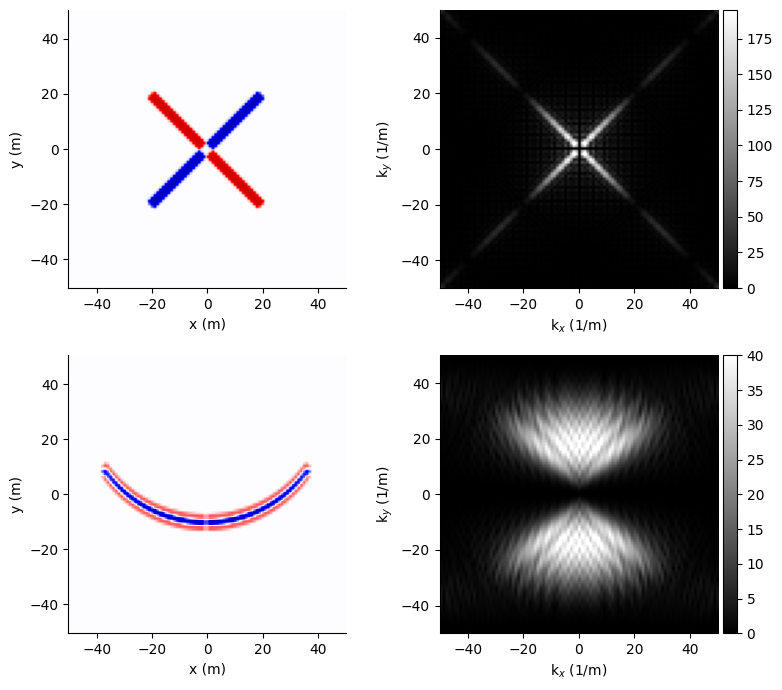

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

image_cross = np.zeros((nx, nx))
image_cross += rasterize([[[30, 30], [70, 70]]], image.shape, lw=2.5)
image_cross -= rasterize([[[70, 30], [30, 70]]], image.shape, lw=2.5)

n=50
image_model = create_wave_arc(n=n, nx=nx)
#Plot 2D Fourier Transform
fig, axs = plt.subplots(2, 2, figsize=(8,7))

axs[0, 0].imshow(image_cross, cmap='seismic_r', vmin=-1.5*image_cross.max(), vmax=1.5*image_cross.max(), origin='lower',
        extent = [-nx/2, nx/2, -nx/2, nx/2])
spec1 = axs[0, 1].imshow(np.abs(np.fft.fftshift(np.fft.fft2(image_cross))),
                cmap='gray',
                extent=(x_vec[0], x_vec[-1], x_vec[0], x_vec[-1]),
                origin='lower',
                vmin=0, vmax=195)

axs[1, 0].imshow(image_model, cmap='seismic_r', vmin=-1.5*image_model.max(), vmax=1.5*image_model.max(), origin='lower',
        extent = [-nx/2, nx/2, -nx/2, nx/2])
spec2 = axs[1, 1].imshow(np.abs(np.fft.fftshift(np.fft.fft2(image_model))),
                cmap='gray',
                extent=(x_vec[0], x_vec[-1], x_vec[0], x_vec[-1]),
                origin='lower',
                vmin=0, vmax=40)

divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(spec1, cax=cax)

divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(spec2, cax = cax)

for ax in [axs[0, 0], axs[1, 0]]:
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')

for ax in [axs[0, 1], axs[1, 1]]:
    ax.set_xlabel('k$_x$ (1/m)')
    ax.set_ylabel('k$_y$ (1/m)')
    #remove spine

for ax in axs.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #set equal
    ax.set_aspect('equal')

plt.tight_layout()